# Feedforward neural network implementation

This notebook contains a Python implementation of a simple, feedforward neural network/multilayer perceptron, including training, written from scratch using NumPy. This implementation supports these features:
* Multi-class classification and regression
* Configurable network architecture, including the number of layers and number of hidden units in each layer.
* Choice of activation function for each hidden layer, from these options: sigmoid, relu, and tanh.
* An implementation of Mini-Batch Gradient Descent with optional Batch Normalization for model training, as well as Stochastic Gradient Descent and Batch Gradient Descent.
* Choice of optimizer from:
  * Gradient Descent
  * Momentum
  * Adam
* Dropout regularization

In [1]:
import abc
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

from sklearn.datasets import make_classification
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import PredictionErrorDisplay

### Cost function

The optimization algorithm minimizes the $\textit{cross-entropy cost}$ for multi-class classification settings:
$$
  J(\boldsymbol{y}, \hat{\boldsymbol{y}}) = -\frac{1}{N} \sum \limits _{i=1} ^N \sum \limits _{k=1} ^K \boldsymbol{y}_{k}^{(i)}log(\hat{\boldsymbol{y}}_{k}^{(i)})
$$
The $\textit{mean squared error}$ is used for regression settings:
$$
  J(\boldsymbol{y}, \hat{\boldsymbol{y}}) = \frac{1}{N} \sum \limits _{i=1} ^N (\boldsymbol{y}^{(i)}-\hat{\boldsymbol{y}}^{(i)})^2
$$



In [2]:
def cross_entropy(Y, Y_hat):
    N = Y.shape[1]
    return -np.sum(np.nan_to_num(Y * np.log(Y_hat), neginf=0.0)) / N

def mean_squared_error(Y, Y_hat):
    return np.mean(np.power(Y - Y_hat, 2))

### Activation functions

There are three activation functions supported for hidden layers:

$sigmoid(\boldsymbol{Z}) = \frac{1}{1+\exp(-\boldsymbol{Z})}$

$relu(\boldsymbol{Z}) = max(0, \boldsymbol{Z})$

$tanh(\boldsymbol{Z}) = \frac{2}{1+\exp(-2\boldsymbol{Z})} - 1$

The softmax function is always used as the activation function for the output layer in classification networks:

$$
  softmax(\boldsymbol{Z})_{i} = \frac{exp(\boldsymbol{Z}_{i})}{\sum \limits _{k=1} ^K exp(\boldsymbol{Z}_{k})}
$$

In [3]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

def tanh(Z):
    return 2 * sigmoid(2 * Z) - 1

def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z), axis=0)

def identity(Z):
    return Z

### Layers

There are two classes that represent a layer of a neural network, both of which are concrete subclasses of the ```BaseLayer``` abstract class: 
* ```Layer```: represents a simple dense layer, whose output is calculated as: $\boldsymbol{A} = a(\boldsymbol{W} \boldsymbol{X} + \boldsymbol{b})$. Initializes the weight matrix as: $\boldsymbol{W}_0 \sim \mathcal{N}(\mathbf{0}, \sqrt{2/n_{\mathcal{l}}})$. Biases are initialized at 0.
* ```BatchNormLayer```: represents a dense layer that applies Batch Normalization prior to the activation function. A layer's output is calculated at each iteration by first normalizing the pre-activation values over the current batch, i.e.:
$$
  \boldsymbol{Z}_t = \boldsymbol{W}_t \boldsymbol{X}_{B_t}
$$
$$
  \boldsymbol{Z}_t^{*} = \frac {\boldsymbol{Z}_t - \boldsymbol{\mu}_{\boldsymbol{Z}_t}} {\sqrt{\boldsymbol{\sigma}_{\boldsymbol{Z}_t}^2+\epsilon}}
$$
$$
  \boldsymbol{A}_t = a(diag(\boldsymbol{\gamma}_t) \boldsymbol{Z}_t^{*} + \boldsymbol{\beta}_t)
$$

The input samples are normalized during inference using exponentially weighted moving averages of the pre-activation values' means and variances, accumulated over all training batches:
$$
  \boldsymbol{\mu}_t = \beta \boldsymbol{\mu}_{t-1} + (1 - \beta \boldsymbol{\mu}_{\boldsymbol{Z}_t}) 
$$
$$
  \boldsymbol{\sigma}_t = \beta \boldsymbol{\sigma}_{t-1}^2 + (1 - \beta \boldsymbol{\sigma}_{\boldsymbol{Z}_t}^2) 
$$

```BaseLayer``` defines these operations that subclasses must implement:

* ```get_parameters```: returns a list of the layer's learnable parameters.
* ```forward```: performs the forward pass and returns the layer's post-activation values.
* ```backward```: performs the backward propagation of errors through the layer and calculates all necessary gradients that are used by the optimizer to update the layer's parameters at each iteration.

In [4]:
class Parameter:
    
    def __init__(self, parameter_values):
        self.parameter_values = parameter_values
        self.gradient = None        

class BaseLayer(abc.ABC):
    
    def __init__(self, num_units, input_size, activation):
        self.num_units = num_units
        self.input_size = input_size        
        self.activation = activation
        self.previous = None
        
    @abc.abstractmethod
    def get_parameters(self):
        raise NotImplementedError
        
    @abc.abstractmethod        
    def forward(self, A, training=False):
        raise NotImplementedError
        
    @abc.abstractmethod
    def backward(self, X, Y):
        raise NotImplementedError
        
    def predict(self, X):
        return self.forward(X, training=False)
    
    def num_parameters(self):
        return np.sum([np.product(parameter.parameter_values.shape) for parameter in self.get_parameters()])
        
class Layer(BaseLayer):
    
    def __init__(self, num_units, input_size, activation):
        super().__init__(num_units, input_size, activation)
        
        # parameters
        self.W = Parameter(np.random.normal(scale=np.sqrt(2 / self.input_size), size=(self.num_units, self.input_size)))
        self.b = Parameter(np.zeros((self.num_units, 1)))
        
        # cache
        self.dZ = None
        self.dA = None        
        self.Z = None        
        
    def get_parameters(self):
        return [self.W, self.b]  

    def forward(self, A, training=False):
        Z = np.dot(self.W.parameter_values, A) + self.b.parameter_values
        if training:
            self.Z = Z
        return self.activation(Z)      
    
    def backward(self, X, Y):    
        
        N = X.shape[1]
        
        A = self.activation(self.Z)
        
        if self.activation == softmax:
            self.dZ = (A - Y) / N
        elif self.activation == identity:
            self.dZ = (A - Y) / N * 2
        elif self.activation == sigmoid:
            self.dZ = self.dA * A * (1 - A)
        elif self.activation == relu:
            self.dZ = self.dA * (self.Z > 0).astype(int)
        elif self.activation == tanh:
            self.dZ = self.dA * (1 - A * A)
        
        A_prev = self.previous.activation(self.previous.Z) if self.previous is not None else X        
        
        self.W.gradient = np.dot(self.dZ, A_prev.T)
        self.b.gradient = np.sum(self.dZ, axis=1, keepdims=True)        

        if self.previous is not None:
            self.previous.dA = np.dot(self.W.parameter_values.T, self.dZ)

class BatchNormLayer(BaseLayer):
    
    def __init__(self, num_units, input_size, activation, momentum=0.99, epsilon=10e-3):
        super().__init__(num_units, input_size, activation)
        self.momentum = momentum
        self.epsilon = epsilon
        
        # parameters
        self.W = Parameter(np.random.normal(scale=np.sqrt(2 / self.input_size), size=(self.num_units, self.input_size)))
        self.gamma = Parameter(np.random.normal(scale=np.sqrt(2 / self.input_size), size=(self.num_units, 1)))
        self.beta = Parameter(np.zeros((self.num_units, 1)))
        
        # cache
        self.Z_centered = None
        self.Z_var = None
        self.Y = None              
        self.dA = None
        
        # population statistics for inference
        self.moving_average_mean = np.zeros((self.num_units, 1))
        self.moving_average_var = np.ones((self.num_units, 1))
        
    def get_parameters(self):
        return [self.W, self.gamma, self.beta]            

    def forward(self, A, training=False):
        Z = np.dot(self.W.parameter_values, A)
        
        if training:
            Z_mean = np.mean(Z, axis=1, keepdims=True)
            self.Z_centered = Z - Z_mean
            self.Z_var = np.var(Z, axis=1, keepdims=True)
            Z_normalized = self.Z_centered / np.sqrt(self.Z_var + self.epsilon)
            self.Y = self.gamma.parameter_values * Z_normalized + self.beta.parameter_values

            self.moving_average_mean = self.moving_average_mean * self.momentum + Z_mean * (1 - self.momentum)
            self.moving_average_var = self.moving_average_var * self.momentum + self.Z_var * (1 - self.momentum)
            
            return self.activation(self.Y)
            
        else:
            Z_normalized = (Z - self.moving_average_mean) / np.sqrt(self.moving_average_var + self.epsilon)
            Y = self.gamma.parameter_values * Z_normalized + self.beta.parameter_values
            return self.activation(Y)

    def backward(self, X, Y):    
        
        N = X.shape[1]
        
        A = self.activation(self.Y)
        
        if self.activation == softmax:
            dY = (A - Y) / N
        elif self.activation == identity:
            dY = (A - Y) / N * 2
        elif self.activation == sigmoid:
            dY = self.dA * A * (1 - A)            
        elif self.activation == relu:
            dY = self.dA * (self.Y > 0).astype(int)
        elif self.activation == tanh:
            dY = self.dA * (1 - A * A)

        self.beta.gradient = np.sum(dY, axis=1, keepdims=True)
        Z_normalized = self.Z_centered / np.sqrt(self.Z_var + self.epsilon)
        self.gamma.gradient = np.sum(dY * Z_normalized, axis=1, keepdims=True)
        dZ_normalized = dY * self.gamma.parameter_values
        dZ_var = dZ_normalized * self.Z_centered * 0.5 / np.power(self.Z_var + self.epsilon, 1.5)
        dZ_centered = dZ_normalized / np.sqrt(self.Z_var + self.epsilon) + dZ_var * 2 * np.ones((self.num_units, N)) * self.Z_centered / N
        dZ_mean = -np.sum(dZ_centered, axis=1, keepdims=True)
        dZ = dZ_centered + dZ_mean * np.ones((self.num_units, N)) / N

        A_prev = self.previous.activation(self.previous.Y) if self.previous is not None else X        
        
        self.W.gradient = np.dot(dZ, A_prev.T)

        if self.previous is not None:
            self.previous.dA = np.dot(self.W.parameter_values.T, dZ)

### Optimizers

Three optimization algorithms are provided:
* ```GradientDescentOptimizer```: updates parameters at each iteration according to: $\boldsymbol{\theta}_t = \boldsymbol{\theta}_{t-1} - \alpha \frac {\partial J} {\partial \boldsymbol{\theta}_t}$
* ```MomentumOptimizer```: replaces the gradient in the update rule with an accumulated exponentially weighted moving average gradient: $\boldsymbol{v}_t = \beta \boldsymbol{v}_{t-1} + (1 - \beta) \frac {\partial J} {\partial \boldsymbol{\theta}_t}$
* ```AdamOptimizer```: uses adaptive estimates of the first and second moments of the gradient in the update rule, i.e.:

$$
  \boldsymbol{v}_t = \beta_1 \boldsymbol{v}_{t-1} + (1 - \beta_1) \frac {\partial J} {\partial \boldsymbol{\theta}_t}
$$
$$
  \boldsymbol{s}_t = \beta_2 \boldsymbol{s}_{t-1} + (1 - \beta_2) \left(\frac {\partial J} {\partial \boldsymbol{\theta}_t}\right)^2
$$
$$
  \boldsymbol{\theta}_t = \boldsymbol{\theta}_{t-1} - \alpha \frac {\boldsymbol{v}_{t}} {\sqrt{\boldsymbol{s}_t + \epsilon}} \frac {\sqrt{1-\beta_2^{t}}} {1-\beta_1^{t}}
$$

In [5]:
class Optimizer(abc.ABC):
    
    def __init__(self, learning_rate=0.1):
        self.learning_rate = learning_rate
        self.parameters = {}
        self.t = 0
        
    @abc.abstractmethod
    def add_parameter(self, parameters):
        raise NotImplementedError
        
    def update_parameters(self):
        self.t = self.t + 1
        for parameter, moments in self.parameters.items():
            parameter.parameter_values = self.parameter_update(parameter, moments)

    @abc.abstractmethod
    def parameter_update(self, parameter, moments):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    
    def __init__(self, learning_rate=0.1):
        super().__init__(learning_rate)
        
    def add_parameter(self, parameter):
        self.parameters[parameter] = parameter       

    def parameter_update(self, parameter, moments):
        return parameter.parameter_values - self.learning_rate * parameter.gradient
        
class MomentumOptimizer(Optimizer):
    
    def __init__(self, learning_rate=0.1, momentum=0.9):
        super().__init__(learning_rate)
        self.momentum = momentum
        
    def add_parameter(self, parameter):
        self.parameters[parameter] = None
        
    def parameter_update(self, parameter, moments):
        moving_average_gradient = self.momentum * moments + (1 - self.momentum) * parameter.gradient if moments is not None else parameter.gradient
        self.parameters[parameter] = moving_average_gradient
        return parameter.parameter_values - self.learning_rate * moving_average_gradient
            
class AdamOptimizer(Optimizer):
    
    def __init__(self, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(learning_rate)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
    def add_parameter(self, parameter):
        self.parameters[parameter] = (None, None) # (momentum, velocity)

    def parameter_update(self, parameter, moments):
        momentum, velocity = moments

        momentum = self.beta1 * momentum + (1 - self.beta1) * parameter.gradient if momentum is not None else parameter.gradient
        velocity = self.beta2 * velocity + (1 - self.beta2) * parameter.gradient * parameter.gradient if velocity is not None else parameter.gradient * parameter.gradient
        
        alpha = self.learning_rate * np.sqrt(1 - np.power(self.beta2, self.t)) / (1 - np.power(self.beta1, self.t))
        
        self.parameters[parameter] = (momentum, velocity)   
        return parameter.parameter_values - alpha * momentum / (np.sqrt(velocity) + self.epsilon)

### Network

The ```Network``` class orchestrates the training and inference of a neural network. It consists of a list of ```layers``` that represent the architecture of the network and an ```optimizer``` that determines the optimization algorithm. The ```Network``` class defines these operations:

* ```add```: inserts a ```BaseLayer``` object as the last layer of the network. The inserted layer is fully connected to the previous layer.
* ```propagate_forward```: performs the forward pass and returns output layer's post-activation values.
* ```propagate_backward```: performs the backward propagation of errors through each layer in the network.
* ```update_parameters```: invokes the optimizer to update the learnable parameters on each iteration.
* ```fit```: runs the optimization algorithm to minimize the cost function over the provided input examples and invokes ```propagate_forward```, ```propagate_backward```, and ```update_parameters``` on each iteration. Returns a list containing the value of the cost function at each iteration.
* ```predict```: returns the final layer's output for the input samples.
* ```print_summary```: prints a summary of the layers that comprise the network.

The class also provides a factory method, ```create_network``` used to construct a ```Network``` object that takes these arguments as input:
* ```input_dim```: the dimension of the input examples.
* ```layer_sizes```: a list containing the number of units in each layer.
* ```learning_rate```: the learning rate used by the optimizer during training.
* ```num_epochs```: the number of passes over the training data.
* ```activation_function```: the activation function to use for all hidden layers, must be one of: (```sigmoid```, ```tanh```, ```relu```). Defaults to ```relu```.
* ```dropout_rate```: the dropout rate to use in all hidden layers. If not ```None``` then the output of unit $i$ during training is: $O_i = \frac{1} {1 - p} X_i A_i$, where $X_i \sim Bernoulli(1-p)$, known as $\textit{inverted dropout}$. Defaults to ```None```.
* ```batch_size```: the batch size used for training with Mini-Batch Gradient Descent. If ```None``` is passed then the network is trained using Batch Gradient Descent. Defaults to ```None```.
* ```batch_normalize```: boolean that indicates if Batch Normalization should be applied prior to the activation function for all layers in the network. Defaults to ```False```.
* ```optimizer```: string that indicates which optimization algorithm to use during training, must be one of (```"gradient_descent"```, ```"momentum"```, ```"adam"```). Defaults to ```"gradient_descent"```.

In [6]:
class Network:
    
    def __init__(self, cost, learning_rate=0.1, num_epochs=100, batch_size=None, optimizer="gradient_descent", dropout_rate=None, **kwargs):
        if cost == "cross_entropy":
            self.cost = cross_entropy
        elif cost == "mean_squared_error":
            self.cost = mean_squared_error
        self.layers = []
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        if optimizer is None or optimizer == "gradient_descent":
            self.optimizer = GradientDescentOptimizer(learning_rate)
        elif optimizer == "momentum":
            self.optimizer = MomentumOptimizer(learning_rate, **kwargs)
        elif optimizer == "adam":
            self.optimizer = AdamOptimizer(learning_rate, **kwargs)
        else:
            raise Exception("optimizer must be one of: ('gradient_descent', 'momentum', 'adam')")
        self.dropout_rate = dropout_rate
        
    def add(self, layer):
        previous = self.layers[-1] if len(self.layers) > 0 else None
        layer.previous = previous
        self.layers.append(layer)
        for parameter in layer.get_parameters():
            self.optimizer.add_parameter(parameter)
        
    def propagate_forward(self, X, training=False):
        A = X
        for layer in self.layers:
            A = layer.forward(A, training)            
            if training and layer.activation != softmax and layer.activation != identity and self.dropout_rate is not None:
                B = np.ones(A.shape)
                dropped = np.random.random(layer.num_units) < self.dropout_rate
                B[dropped,:] = 0.
                A *= B
                A *= 1 / (1 - self.dropout_rate)                          
        return A
    
    def propagate_backward(self, X, Y):
        for layer in reversed(self.layers):
            layer.backward(X, Y)

    def update_parameters(self):
        self.optimizer.update_parameters()

    def fit(self, X, Y):
        
        if len(Y.shape) == 1:
            if self.cost == cross_entropy:
                # if Y contains the class labels then reshape into a one-hot encoded matrix            
                K = np.unique(Y).shape[0]
                Y = np.eye(K)[Y].T
            elif self.cost == mean_squared_error:
                Y = Y[np.newaxis, :]

        if Y.shape[0] != self.layers[-1].num_units:
            raise Exception(f"Y.shape[0] must be equal to {self.layers[-1].num_units}, the number of units in the output layer")
        
        num_batches = int(np.ceil(X.shape[1]/self.batch_size)) if self.batch_size is not None else 1
            
        costs = np.zeros(self.num_epochs)
  
        for i in range(self.num_epochs):
            
            # calculate cost over the entire training dataset at the beginning of each epoch
            A = self.propagate_forward(X)
            C = self.cost(Y, A)
            costs[i] = C
            
            indices = np.arange(X.shape[1])
            np.random.shuffle(indices)            
            batches = np.array_split(indices, num_batches)
            
            for batch in batches:
                X_batch = X[:,batch]
                Y_batch = Y[:,batch]
                
                # propagate forward to calculate predictions
                A = self.propagate_forward(X_batch, training=True)

                # propagate backward to calculate gradients
                self.propagate_backward(X_batch, Y_batch)

                # update parameters
                self.update_parameters()
        
        return costs

    def predict(self, X, probability=False):
        return self.propagate_forward(X, training=False)        
    
    def print_summary(self):
        layer_summaries = [[0, "Input", (self.layers[0].input_size, None), 0]]
        total_parameters = 0
        for i in range(len(self.layers)):
            layer = self.layers[i]
            layer_type = type(layer).__name__
            activation = layer.activation.__name__
            output_shape = (layer.num_units, None)
            num_parameters = layer.num_parameters()
            layer_summaries.append([i+1, f"{layer_type} ({activation})", output_shape, num_parameters])
            total_parameters += num_parameters
        print(tabulate(layer_summaries, headers=["Layer", "Type", "Output shape", "Parameters"]))
        print(f"Total parameters: {total_parameters}")
    
    @staticmethod
    def create_network(input_dim, layer_sizes, cost_function, learning_rate, num_epochs, activation_function=relu, dropout_rate=None, batch_size=None, batch_normalize=False, optimizer="gradient_descent", **kwargs):
        
        if batch_normalize and (batch_size is None or batch_size <= 1):
            raise Exception("Must provide a valid batch_size if batch_normalize=True")
        
        if not isinstance(activation_function, list):
            activation_function = [activation_function] * (len(layer_sizes) - 1)
            
        if len(activation_function) != len(layer_sizes) - 1:
            raise Exception("Length of provided list of activation functions must equal the number of hidden units!")            
        
        network = Network(cost=cost_function, learning_rate=learning_rate, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer, dropout_rate=dropout_rate, **kwargs)
        
        for i in range(len(layer_sizes)):
            if i < len(layer_sizes) - 1:
                activation = activation_function[i]
            else:
                if cost_function == "mean_squared_error":
                    activation = identity
                elif cost_function == "cross_entropy":
                    activation = softmax
            input_size = layer_sizes[i-1] if i > 0 else input_dim
            layer = BatchNormLayer(layer_sizes[i], input_size, activation) if batch_normalize else Layer(layer_sizes[i], input_size, activation)
            network.add(layer)   
            
        return network

## Classification examples

The cells below train neural network classifiers on two simple datasets:

* A synthetic dataset generated using ```sklearn.datasets.make_classification``` with 4 classes and 2 dimensional input.
* The MNIST handwritten digit image dataset provided by ```tensorflow.keras.datasets.mnist```.

### Synthetic data

The neural network classifier for the synthetic data has 2 hidden layers with 20 and 10 hidden units, respectively, that use the tanh activation function. Model training performs 2,000 passes over the input data and uses a batch size of 20. 

In [7]:
X, Y = make_classification(n_samples=1000, n_classes=4, n_features=2, n_redundant=0, n_clusters_per_class=1)
X, Y = X.T, Y

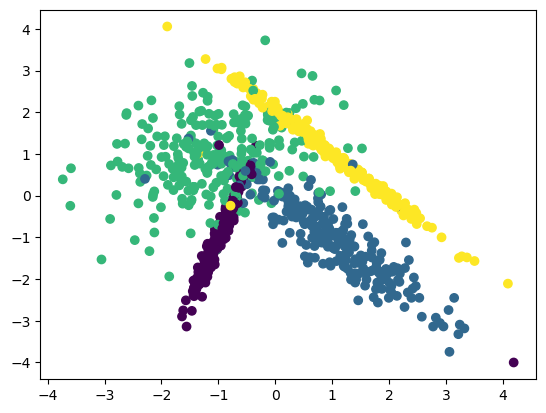

In [8]:
ax = plt.subplot()

ax.scatter(X[0], X[1], c=Y)
plt.show()

In [9]:
network = Network.create_network(X.shape[0], 
                                 [20, 10, 4],
                                 "cross_entropy",                                 
                                 learning_rate=0.1, 
                                 num_epochs=2000, 
                                 activation_function=tanh,                                  
                                 batch_size=20
                                )

network.print_summary()

costs = network.fit(X, Y)

  Layer  Type             Output shape      Parameters
-------  ---------------  --------------  ------------
      0  Input            (2, None)                  0
      1  Layer (tanh)     (20, None)                60
      2  Layer (tanh)     (10, None)               210
      3  Layer (softmax)  (4, None)                 44
Total parameters: 314


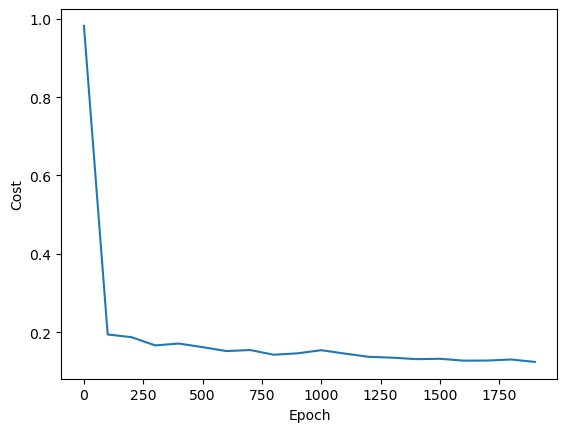

Accuracy: 0.956


In [10]:
plt.plot(list(range(0, len(costs), 100)), [costs[i] for i in range(len(costs)) if i % 100 == 0])
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

Y_pred = np.argmax(network.predict(X), axis=0)
print(f"Accuracy: {np.mean(Y == Y_pred)}")

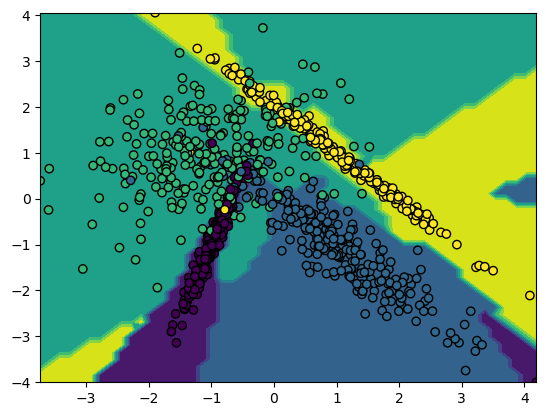

In [11]:
# plot the decision boundaries
feature_1, feature_2 = np.meshgrid(
    np.linspace(X[0,:].min(), X[0,:].max()),
    np.linspace(X[1,:].min(), X[1,:].max())
)
grid = np.vstack([feature_1.ravel(), feature_2.ravel()])
y_pred = np.reshape(np.argmax(network.predict(grid), axis=0), feature_1.shape)
display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)
display.plot()
display.ax_.scatter(
     X[0,:], X[1,:], c=Y, edgecolor="black"
)
plt.show()

### MNIST

The neural network classifier for the MNIST handwritten digit image data has a single hidden layer with 128 hidden units. The model training applies Batch Normalization prior to the activation function in both layers with a batch size of 32 and uses the Adam optimizer. The classification accuracy is evaluated using the test set. 

In [12]:
from tensorflow.keras.datasets.mnist import load_data

(x_train, y_train), (x_test, y_test) = load_data()

x_train_flatten = x_train.reshape(x_train.shape[0], -1).T
x_test_flatten = x_test.reshape(x_test.shape[0], -1).T

x_train_flatten = x_train_flatten / 255
x_test_flatten = x_test_flatten / 255

In [13]:
mnist_network = Network.create_network(x_train_flatten.shape[0], 
                                 [128, 10], 
                                 "cross_entropy",
                                 learning_rate=0.01, 
                                 num_epochs=10, 
                                 batch_size=32, 
                                 batch_normalize=True, 
                                 optimizer="adam")

mnist_network.print_summary()

costs = mnist_network.fit(x_train_flatten, y_train)

  Layer  Type                      Output shape      Parameters
-------  ------------------------  --------------  ------------
      0  Input                     (784, None)                0
      1  BatchNormLayer (relu)     (128, None)           100608
      2  BatchNormLayer (softmax)  (10, None)              1300
Total parameters: 101908


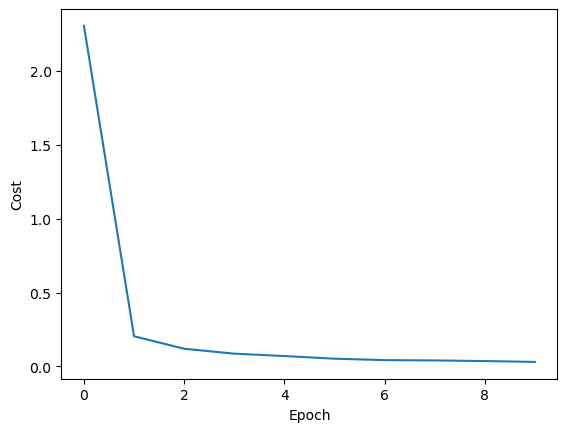

Accuracy: 0.9771


In [14]:
plt.plot(costs)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

y_pred = np.argmax(mnist_network.predict(x_test_flatten), axis=0)
print(f"Accuracy: {np.mean(y_test == y_pred)}")

## Regression examples
The cells below train neural networks for two simple regression tasks:

* A synthetic dataset generated using a known functional form and a single predictor
* The Boston Housing price regression dataset provided by ```tensorflow.keras.datasets.boston_housing```

### Synthetic data

The synthetic data consists of 1,000 randomly generated samples from the simple linear model:
$$
y_i = 120 -3 * (x_i - 5)^2 + \epsilon_i 
$$
$$
\epsilon_i \sim \mathcal{N}(0, 10)
$$

The neural network has 2 hidden layers with 300 and 200 hidden units, respectively, that both use the tanh activation function. Model training performs 1,000 passes over the input data with a batch size of 32.

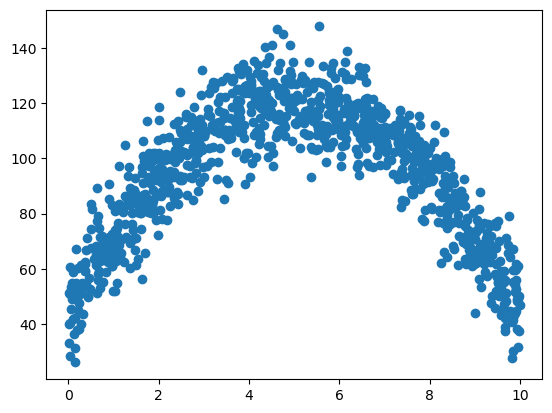

In [15]:
X = np.random.uniform(size=(1, 1000))*10
Y = -3 * np.power(X - 5, 2) + 120 + np.random.normal(scale=10.0, size=(1, X.shape[1]))

plt.scatter(X, Y)
plt.show()

In [16]:
network = Network.create_network(X.shape[0], 
                                 [300, 200, 1],
                                 "mean_squared_error",                                 
                                 learning_rate=0.001, 
                                 num_epochs=1000, 
                                 activation_function=tanh,
                                 batch_size=32,
                                 optimizer="adam"
                                )

network.print_summary()

costs = network.fit(X, Y)

  Layer  Type              Output shape      Parameters
-------  ----------------  --------------  ------------
      0  Input             (1, None)                  0
      1  Layer (tanh)      (300, None)              600
      2  Layer (tanh)      (200, None)            60200
      3  Layer (identity)  (1, None)                201
Total parameters: 61001


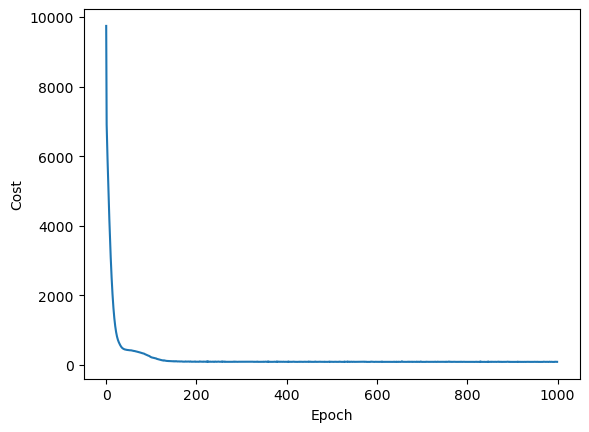

Mean squared error: 90.12342179526517


In [17]:
plt.plot(costs)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

Y_pred = network.predict(X)
print(f"Mean squared error: {mean_squared_error(Y, Y_pred)}")

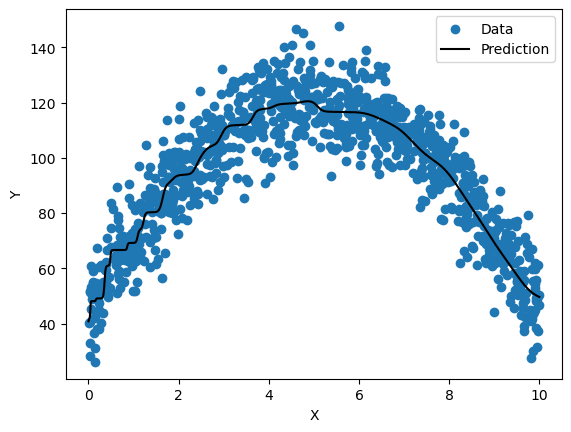

In [18]:
plt.scatter(X, Y, label="Data")
X_grid = np.linspace(0, 10, num=1000)[np.newaxis, :]
plt.plot(X_grid.T, network.predict(X_grid).T, color="k", label="Prediction")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

### Boston Housing price prediction
The neural network model for the Boston Housing price data has 2 hidden layers with 128 hidden units and applies Batch Normalization with a batch size of 32 for training. The mean squared error is calculated for the test set.

In [19]:
from tensorflow.keras.datasets.boston_housing import load_data

(x_train, y_train), (x_test, y_test) = load_data()

x_train = x_train.T
x_test = x_test.T

In [20]:
housing_network = Network.create_network(x_train.shape[0], 
                                 [200, 100, 1],
                                 "mean_squared_error",                                 
                                 learning_rate=0.1, 
                                 num_epochs=100, 
                                 activation_function=relu,
                                 batch_size=32,
                                 batch_normalize=True,
                                 optimizer="adam"
                                )

housing_network.print_summary()

costs = housing_network.fit(x_train, y_train)

  Layer  Type                       Output shape      Parameters
-------  -------------------------  --------------  ------------
      0  Input                      (13, None)                 0
      1  BatchNormLayer (relu)      (200, None)             3000
      2  BatchNormLayer (relu)      (100, None)            20200
      3  BatchNormLayer (identity)  (1, None)                102
Total parameters: 23302


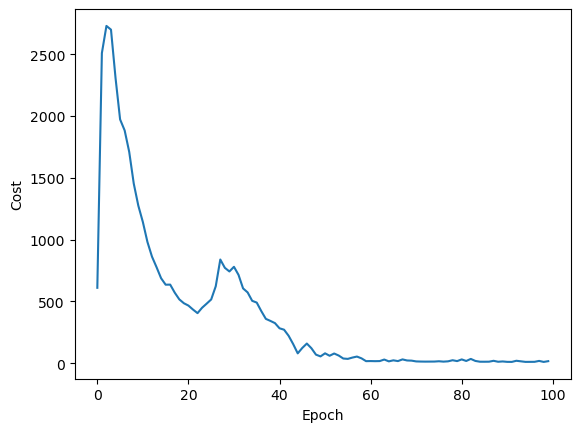

In [21]:
plt.plot(costs)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

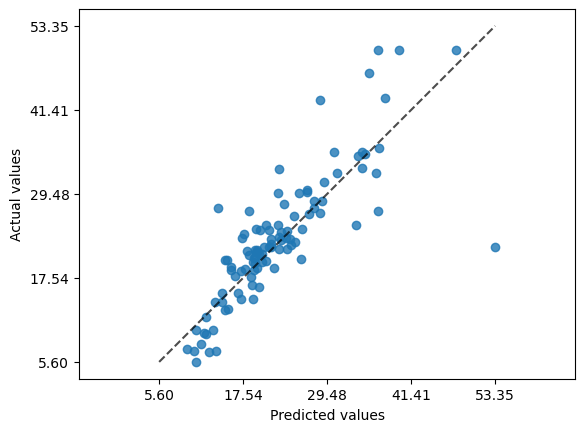

Mean squared error: 28.290523983864375


In [22]:
y_pred = housing_network.predict(x_test)

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred,
    kind="actual_vs_predicted"
)
plt.show()

print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")